In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import math

import bokeh.embed
import bokeh.io
import bokeh.layouts
import bokeh.models
import bokeh.palettes
import bokeh.plotting
import bokeh.transform

import sys
sys.path.append("/Users/missd/Desktop/6. Semester/6. Model Deployment Maintenance/MDM - Python Projekt/src/")
import mdm_python.data.db_wetter2 as db

bokeh.io.output_notebook()

Loading BokehJS ...

In [16]:
data = db.extract_daily_average_weather()
data

,avg_temp,min_temp,max_temp,rain,wind_speed,clouds
date,,,,,,
2022-05-09 00:00:00+00:00,10.468866,-1.8,21.4,0.028264,1.542406,clouds
2022-05-10 00:00:00+00:00,12.242014,-2.3,24.3,0.000671,1.386188,clouds
2022-05-11 00:00:00+00:00,14.441782,0.3,28.9,0.004954,1.997621,clouds
2022-05-12 00:00:00+00:00,14.614468,2.3,28.1,0.026667,1.877090,clouds
2022-05-13 00:00:00+00:00,13.198264,1.7,22.8,0.094225,1.448206,clouds
...,...,...,...,...,...,...
2024-03-08 00:00:00+00:00,0.025000,-12.3,11.0,0.020938,2.567483,clouds
2024-03-09 00:00:00+00:00,2.076389,-10.3,13.7,0.069630,2.857928,clouds
2024-03-10 00:00:00+00:00,1.819213,-12.8,11.7,0.551609,2.507137,clouds


In [20]:
def weather_stacked_area_overview_plot(data):

    day_source = bokeh.models.ColumnDataSource(data=data)
    middle = data.index[len(data) // 2]
    selection_range = pd.Timedelta("20 days")


    # Selected-Part-Plot
    p = bokeh.plotting.figure(
        height=300,
        width=800,
        x_axis_type="datetime",
        x_axis_location="above",
        x_range=(middle - selection_range, middle + selection_range),
    )

    for tool in [bokeh.models.PanTool, bokeh.models.WheelZoomTool]:
        p.select_one(tool).dimensions = "width"

    p.yaxis.axis_label = 'Weather'

    # Overview-Plot
    overview = bokeh.plotting.figure(
        title="Drag the middle and edges of the selection box to change the range above",
        height=130,
        width=800,
        y_range=p.y_range,
        x_axis_type="datetime",
        y_axis_type=None,
        tools="hover",
        toolbar_location=None,
    )

    for fig in [p, overview]:
        fig.extra_y_ranges['rain'] = bokeh.models.Range1d(0, data.rain.max()+1, bounds=(0, None))

        fig.vbar(
            x='date',
            top="rain",
            source=day_source,
            color="#0072B2",
            legend_label="Rain",
            width=pd.Timedelta(hours=20),
            y_range_name="rain",
        )

        fig.line(
            x='date',
            y="avg_temp",
            source=day_source,
            color="#D55E00",
            legend_label="Temperature",
        )

    ax2 = bokeh.models.LinearAxis(y_range_name="rain", axis_label="rain [mm/h]")
    ax2.axis_label_text_color = "navy"
    p.add_layout(ax2, 'right')

    p.legend.location = "top_left"

    range_tool = bokeh.models.RangeTool(x_range=p.x_range)
    range_tool.overlay.fill_color = "navy"
    range_tool.overlay.fill_alpha = 0.2

    overview.ygrid.grid_line_color = None
    overview.add_tools(range_tool)

    fig = bokeh.layouts.column(p, overview)

    bokeh.plotting.show(fig)

    return fig

In [10]:
def wetter2_boxplot(data):
    temp = data.avg_temp
    plot = plt.boxplot(temp)
    return plot

In [11]:
def wetter2_histplot(data):
    temp = data.avg_temp
    plot = plt.hist(temp, edgecolor='black', linewidth=1.2)
    return plot

In [21]:
weather_overview_plot(data)

Column(id='p1276', ...)

{'whiskers': [<matplotlib.lines.Line2D at 0x13f1c0f50>,
 'caps': [<matplotlib.lines.Line2D at 0x13f1c3850>,
 'boxes': [<matplotlib.lines.Line2D at 0x13f1bbf90>],
 'medians': [<matplotlib.lines.Line2D at 0x13f127e50>],
 'fliers': [<matplotlib.lines.Line2D at 0x13f1277d0>],
 'means': []}

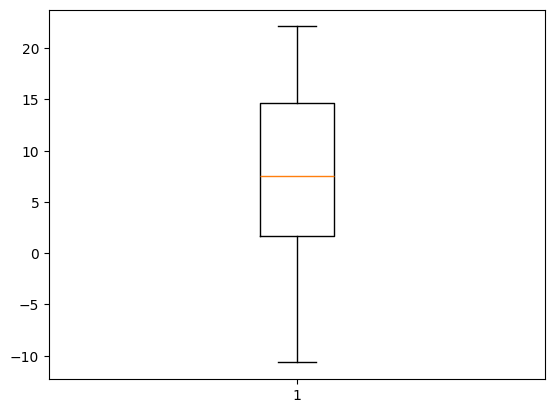

In [18]:
wetter2_boxplot(data)

(array([  9.,  30.,  34., 120., 107.,  62.,  72., 110.,  89.,  36.]),
 array([-10.6587963 ,  -7.38127315,  -4.10375   ,  -0.82622685,
          2.4512963 ,   5.72881944,   9.00634259,  12.28386574,
         15.56138889,  18.83891204,  22.11643519]),
 <BarContainer object of 10 artists>)

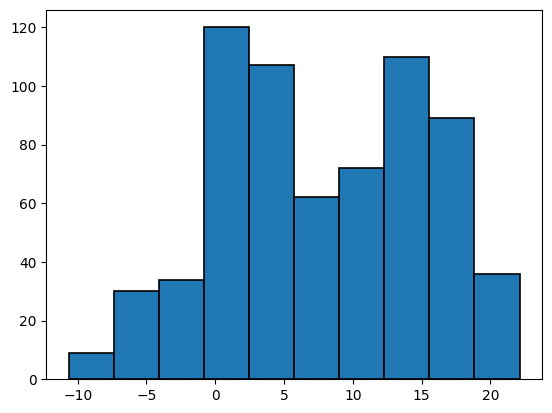

In [19]:
wetter2_histplot(data)